Source: [NYC Taxi and Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

[Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

### Overwiew
The primary objective of this project is to build a regression model that predicts taxi cab demand by time by location.


**The isuue: demand in taxi / car share industry**
- Drivers vs Customers (Supply vs Demand)
- Companies need to forecast demand

**Solution: Predict taxi demand per hour by location**

Operations team can adjust the distribution of drivers (send drivers to high demand areas)

### Project Steps
1. Load dataset
2. Explore dataset for any unusual values
3. Conduct exploratory data analysis
4. Perform data cleaning and data analysis steps to understand unusual variables (e.g., outliers)
5. Use descriptive statistics to learn more about the data
6. Create and run a regression model

## 1. Loading, inspecting and validating the data

In [1]:
import pandas as pd
from pathlib import Path
import requests
import seaborn as sns
import matplotlib.pyplot as plt
# %pip install pyarrow

In [2]:
def get_taxi_data(year: int, month: int) -> str:
    """Get TLC data"""
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"
    response = requests.get(url)

    if response.status_code == 200:
        path = f"../data/raw/rides_{year}_{month:02}.parquet"
        with open(path, 'wb') as file:
            file.write(response.content)
        return path
    else:   
        raise RuntimeError(f"Failed to download {url}")

In [3]:
def merge_taxi_data(start_year: int, end_year: int) -> pd.DataFrame:
    """Merge TLC data. 
    The function is writen with concideration 
    that I might decide use more data in the future"""
    df = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            file_path = get_taxi_data(year, month)
            df_month = pd.read_parquet(file_path)
            df.append(df_month)
    merged_data = pd.concat(df, ignore_index=True)
    return merged_data

In [4]:
# Range of years for which to download and merge the data. Set for now for 2023 only
start_year = 2023
end_year = 2023

merged_data = merge_taxi_data(start_year, end_year)
merged_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,NaN
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,NaN
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,NaN
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,NaN
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,NaN


In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

In [6]:
merged_data.isnull().sum() / len(merged_data) * 100

VendorID                  0.000000
tpep_pickup_datetime      0.000000
tpep_dropoff_datetime     0.000000
passenger_count           3.417772
trip_distance             0.000000
RatecodeID                3.417772
store_and_fwd_flag        3.417772
PULocationID              0.000000
DOLocationID              0.000000
payment_type              0.000000
fare_amount               0.000000
extra                     0.000000
mta_tax                   0.000000
tip_amount                0.000000
tolls_amount              0.000000
improvement_surcharge     0.000000
total_amount              0.000000
congestion_surcharge      3.417772
airport_fee              92.182184
Airport_fee              11.235588
dtype: float64

**Observations and insights**

Out of 38,310,226 columns there are a few columns with a low number of missing values (less than 3,5%):

| Field Name | Description |
| -------- | ------- |
| Passenger_count | The number of passengers in the vehicle. **This is a driver-entered value**|
| RateCodeID |The final rate code in effect at the end of the trip. **1= Standard rate;  2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride** |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. **Y= store and forward trip; N= not a store and forward trip** |
| Congestion_Surcharge | Total amount collected in trip for NYS congestion surcharge |
| Airport_fee | $1.25 for pick up only at LaGuardia and John F. Kennedy Airports |

After investigating airport_fee columns the decision was made to merge them and to drop the original ones, as they record the same indormation.

In [7]:
merged_data['AirPort_fee'] = merged_data['airport_fee'].combine_first(merged_data['Airport_fee'])

In [8]:
merged_data.drop(columns=['airport_fee', 'Airport_fee'], inplace=True)

In [9]:
merged_data.isnull().sum() / len(merged_data) * 100

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.417772
trip_distance            0.000000
RatecodeID               3.417772
store_and_fwd_flag       3.417772
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.417772
AirPort_fee              3.417772
dtype: float64

In [10]:
missing_data = merged_data[['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge', 'AirPort_fee']].isnull()
merged_data[missing_data.any(axis=1)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee
2995023,1,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,None,142,79,0,20.13,0.0,0.5,0.00,0.0,1.0,24.13,NaN,NaN
2995024,1,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,None,237,263,0,12.00,1.0,0.5,2.55,0.0,1.0,21.55,NaN,NaN
2995025,2,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,None,24,41,0,12.80,0.0,0.5,2.14,0.0,1.0,16.44,NaN,NaN
2995026,2,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,None,88,229,0,24.51,0.0,0.5,4.28,0.0,1.0,32.79,NaN,NaN
2995027,2,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,None,232,263,0,32.30,0.0,0.5,7.26,0.0,1.0,43.56,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38310221,2,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,NaN,None,233,163,0,12.08,0.0,0.5,0.00,0.0,1.0,16.08,NaN,NaN
38310222,2,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,NaN,None,48,48,0,25.98,0.0,0.5,0.00,0.0,1.0,27.48,NaN,NaN
38310223,2,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,NaN,None,196,198,0,16.68,0.0,0.5,0.00,0.0,1.0,18.18,NaN,NaN
38310224,2,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,NaN,None,140,148,0,19.64,0.0,0.5,0.00,0.0,1.0,23.64,NaN,NaN


**Observations and insights**

Now all five columns has the same amount (exactly 3.417772%) of missing values.

Those missing values are more likely caused by *data collection errors*: such as errors in the data collection process, taximeter equipment failures, and human error. The data collection errors (missing data) are systematic throughout 5 fields / features (appear simultaneously in all of them).

As number of missing values are low, these won't affect the analysis in a meaningfull way. Also, those particular columns are redundant for the prediction purposes.

In [11]:
merged_data.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee
count,3.831023e+07,38310226,38310226,3.700087e+07,3.831023e+07,3.700087e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.831023e+07,3.700087e+07,3.700087e+07
mean,1.738894e+00,2023-07-02 22:47:58.448232,2023-07-02 23:04:41.459181,1.370426e+00,4.088946e+00,1.641906e+00,1.651755e+02,1.639500e+02,1.184585e+00,1.952225e+01,1.556057e+00,4.856167e-01,3.522265e+00,5.897361e-01,9.794487e-01,2.846194e+01,2.264610e+00,1.400666e-01
min,1.000000e+00,2001-01-01 00:06:49,1970-01-20 10:16:32,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.087300e+03,-3.917000e+01,-5.000000e-01,-4.110000e+02,-9.130000e+01,-1.000000e+00,-1.094050e+03,-2.500000e+00,-1.750000e+00
25%,1.000000e+00,2023-04-02 18:25:17,2023-04-02 18:43:06.250000,1.000000e+00,1.040000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.595000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2023-06-27 18:43:55,2023-06-27 18:59:09,1.000000e+00,1.790000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.800000e+00,0.000000e+00,1.000000e+00,2.100000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2023-10-06 21:55:14,2023-10-06 22:11:37,1.000000e+00,3.400000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.190000e+01,2.500000e+00,5.000000e-01,4.410000e+00,0.000000e+00,1.000000e+00,3.072000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-01-03 19:42:57,2024-01-03 20:15:55,9.000000e+00,3.457294e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.869836e+05,1.000250e+04,5.316000e+01,4.174000e+03,6.655600e+02,1.000000e+00,3.869876e+05,2.750000e+00,1.750000e+00
std,4.443591e-01,NaN,NaN,8.925924e-01,2.412509e+02,7.427351e+00,6.399765e+01,6.985543e+01,5.562740e-01,7.572729e+01,2.450399e+00,1.095629e-01,4.147060e+00,2.200999e+00,1.991462e-01,7.712821e+01,7.971481e-01,4.686429e-01


## 2. Understanding the data - investigating the variables

In [12]:
df_sort = merged_data.sort_values(['trip_distance'],ascending=False)
df_sort.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee
25178451,2,2023-08-15 04:02:00,2023-08-15 04:13:00,NaN,345729.44,NaN,None,100,263,0,13.27,0.0,0.5,0.00,0.00,1.0,17.27,NaN,NaN
16115613,2,2023-05-11 09:30:00,2023-05-11 09:57:00,NaN,342344.85,NaN,None,116,239,0,-0.11,0.0,0.5,0.00,0.00,1.0,3.89,NaN,NaN
5959075,2,2023-02-21 05:19:00,2023-02-21 05:36:00,NaN,335004.33,NaN,None,142,42,0,17.75,0.0,0.5,2.18,0.00,1.0,23.93,NaN,NaN
12672047,2,2023-04-30 18:37:00,2023-04-30 19:02:00,NaN,296881.42,NaN,None,233,151,0,28.39,0.0,0.5,6.48,0.00,1.0,38.87,NaN,NaN
28053740,2,2023-09-28 13:35:00,2023-09-28 14:53:00,NaN,265869.44,NaN,None,14,140,0,76.02,0.0,0.5,0.00,6.94,1.0,86.96,NaN,NaN
3046991,2,2023-01-23 17:14:00,2023-01-23 17:20:00,NaN,258928.15,NaN,None,238,239,0,13.65,0.0,0.5,3.53,0.00,1.0,21.18,NaN,NaN
25162910,2,2023-08-10 02:05:00,2023-08-10 02:17:00,NaN,232976.75,NaN,None,42,239,0,14.45,0.0,0.5,3.69,0.00,1.0,22.14,NaN,NaN
3009826,2,2023-01-07 18:18:00,2023-01-07 18:47:00,NaN,225987.37,NaN,None,261,263,0,56.49,0.0,0.5,12.10,0.00,1.0,72.59,NaN,NaN
9369796,2,2023-03-26 14:43:00,2023-03-26 15:12:00,NaN,216986.96,NaN,None,79,239,0,28.71,0.0,0.5,6.54,0.00,1.0,39.25,NaN,NaN
31550098,2,2023-10-24 08:15:00,2023-10-24 08:32:00,NaN,205544.17,NaN,None,229,236,0,23.46,0.0,0.5,3.74,0.00,1.0,28.70,NaN,NaN


**Observations and insights**

Longest rides are more than 345K miles. That seems unusually high, especially the top few values. Visually checking the time it took to travel and total amount paid indicates that the recorded distance reported by the taximeter has errors.

In [13]:
total_amount_sorted = merged_data.sort_values(['total_amount'], ascending=False)
total_amount_sorted.head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee
17439335,1,2023-06-12 13:33:06,2023-06-12 13:44:13,3.0,1.50,1.0,N,100,50,2,386983.63,2.50,0.5,0.00,0.00,1.0,386987.63,2.5,0.00
25349953,1,2023-09-02 15:15:39,2023-09-02 16:12:39,2.0,21.30,2.0,N,239,132,2,187502.96,2.50,0.5,0.00,6.94,1.0,187513.90,2.5,0.00
25555738,1,2023-09-05 10:16:13,2023-09-05 10:20:56,1.0,0.70,1.0,N,249,90,2,143163.45,2.50,0.5,0.00,0.00,1.0,143167.45,2.5,0.00
26249203,1,2023-09-11 14:54:55,2023-09-11 14:54:55,1.0,0.00,1.0,Y,43,264,2,19152.90,10002.50,0.5,0.00,0.00,1.0,29156.90,2.5,0.00
27892250,1,2023-09-30 17:58:34,2023-09-30 17:58:34,0.0,0.00,99.0,Y,163,264,1,12015.47,0.00,0.0,0.00,0.00,0.0,12015.47,0.0,0.00
31549066,1,2023-10-23 20:43:13,2023-10-23 21:05:45,NaN,0.00,NaN,None,48,125,0,6339.00,0.00,0.0,0.00,0.00,0.0,6339.00,NaN,NaN
14388207,2,2023-05-16 10:12:28,2023-05-16 14:47:02,6.0,40.81,1.0,N,239,264,2,6300.90,0.00,0.5,0.00,0.00,1.0,6304.90,2.5,0.00
36222775,1,2023-12-12 07:51:03,2023-12-12 07:51:03,0.0,0.00,99.0,N,264,264,3,95.16,0.00,0.0,4174.00,0.00,0.0,4269.16,0.0,0.00
9952970,2,2023-04-06 14:08:51,2023-04-06 19:11:17,2.0,12.58,4.0,N,216,265,2,2449.50,0.00,0.5,0.00,0.00,1.0,2451.00,0.0,0.00
37232285,1,2023-12-20 18:49:49,2023-12-20 19:16:51,1.0,6.70,1.0,N,233,40,3,2320.11,51.68,0.0,0.00,0.00,1.0,2372.79,2.5,0.00


**Observations and insights**

Few top values are quite high, with first three values being significantly higher than the others.

In [14]:
total_amount_sorted.tail(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee
15843478,2,2023-05-29 16:34:46,2023-05-29 18:32:40,1.0,115.01,4.0,N,132,265,4,-740.10,0.0,0.0,0.0,-8.30,-1.0,-749.40,0.0,0.00
2849551,2,2023-01-30 13:23:56,2023-01-30 13:24:08,1.0,0.00,5.0,N,182,182,3,-750.00,0.0,0.0,0.0,0.00,-1.0,-751.00,0.0,0.00
19115608,2,2023-06-28 09:45:57,2023-06-28 09:46:10,2.0,0.00,5.0,N,265,265,2,-750.00,0.0,0.0,0.0,0.00,-1.0,-751.00,0.0,0.00
5054337,2,2023-02-20 16:33:00,2023-02-20 16:34:02,4.0,0.18,5.0,N,246,246,3,-754.05,0.0,0.0,0.0,0.00,-1.0,-757.55,-2.5,0.00
35080508,2,2023-12-02 08:56:50,2023-12-02 10:44:36,1.0,118.05,4.0,N,132,265,4,-756.20,0.0,0.0,0.0,-6.94,-1.0,-765.89,0.0,-1.75
12568248,2,2023-04-30 19:01:36,2023-05-01 12:10:26,1.0,27.92,1.0,N,83,83,4,-768.10,0.0,-0.5,0.0,0.00,-1.0,-769.60,0.0,0.00
25997487,2,2023-09-09 00:28:23,2023-09-09 00:28:37,2.0,0.00,5.0,N,265,265,4,-845.00,0.0,0.0,50.0,0.00,-1.0,-796.00,0.0,0.00
34028474,2,2023-11-22 17:45:55,2023-11-22 17:46:01,2.0,0.00,5.0,N,219,219,4,-800.00,0.0,0.0,0.0,0.00,-1.0,-801.00,0.0,0.00
12539166,2,2023-04-30 14:21:36,2023-04-30 14:22:11,4.0,0.08,5.0,N,130,130,4,-800.00,0.0,0.0,0.0,0.00,-1.0,-801.00,0.0,0.00
12539168,2,2023-04-30 14:27:50,2023-04-30 16:18:30,4.0,77.68,5.0,N,93,265,4,-800.00,0.0,0.0,0.0,-6.55,-1.0,-807.55,0.0,0.00


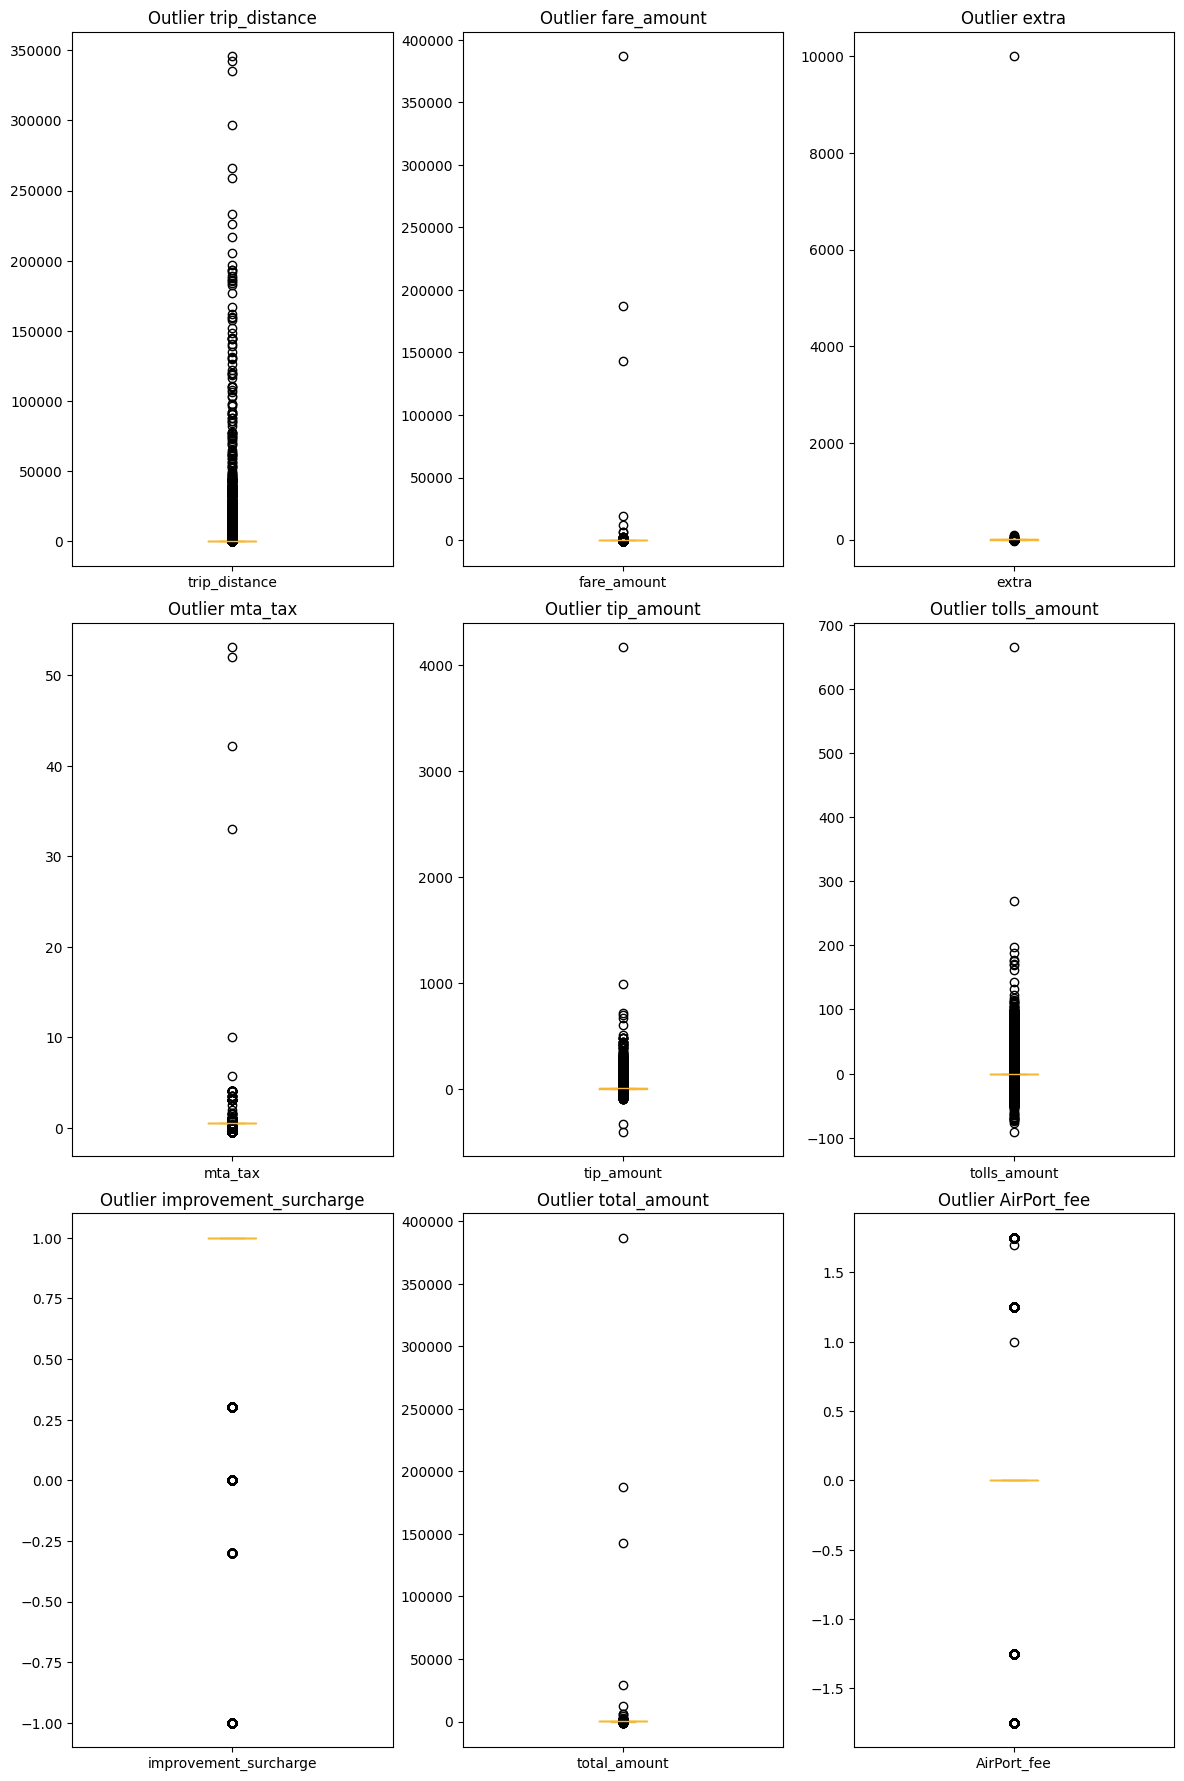

In [15]:
subplt, axs = plt.subplots(3,3, figsize=(12, 18))
subplt.tight_layout(pad=2.0)
col, row = 0,0
float_mask = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount' , \
               'improvement_surcharge', 'total_amount', 'AirPort_fee']

for column in float_mask:
    try:
        if row == 3 and col < 3:
            col = col+1
            row = 0
        merged_data[column].plot(kind="box", ax=axs[col][row], title=f'Outlier {column}', color='#f7b731')
        row = row + 1
    except:
        pass

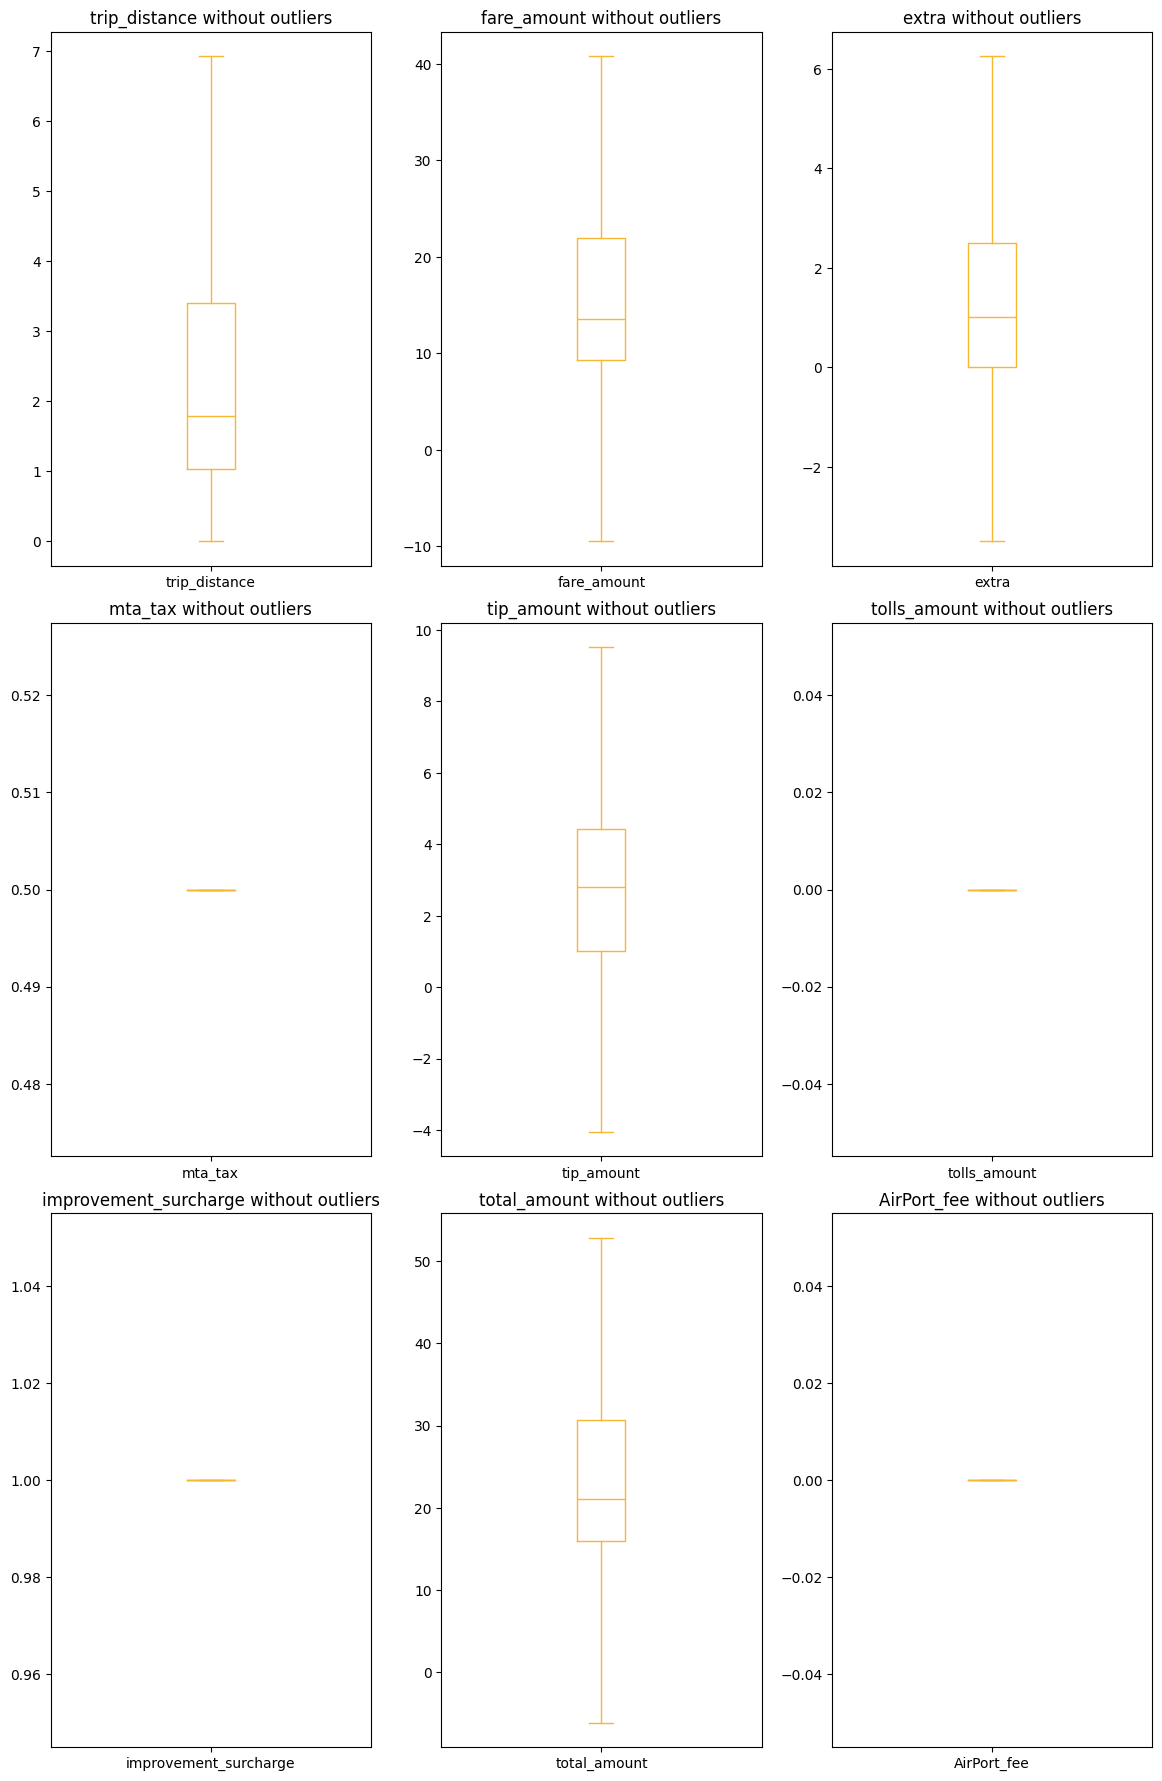

In [16]:
subplt, axs = plt.subplots(3,3, figsize=(12, 18))
subplt.tight_layout(pad=2.0)
col, row = 0,0

for column in float_mask:
    try:
        if row == 3 and col < 3:
            col = col+1
            row = 0
        merged_data[column].plot(kind="box", ax=axs[col][row], title=f'{column} without outliers', color='#f7b731', showfliers=False)
        row = row + 1
    except:
        pass

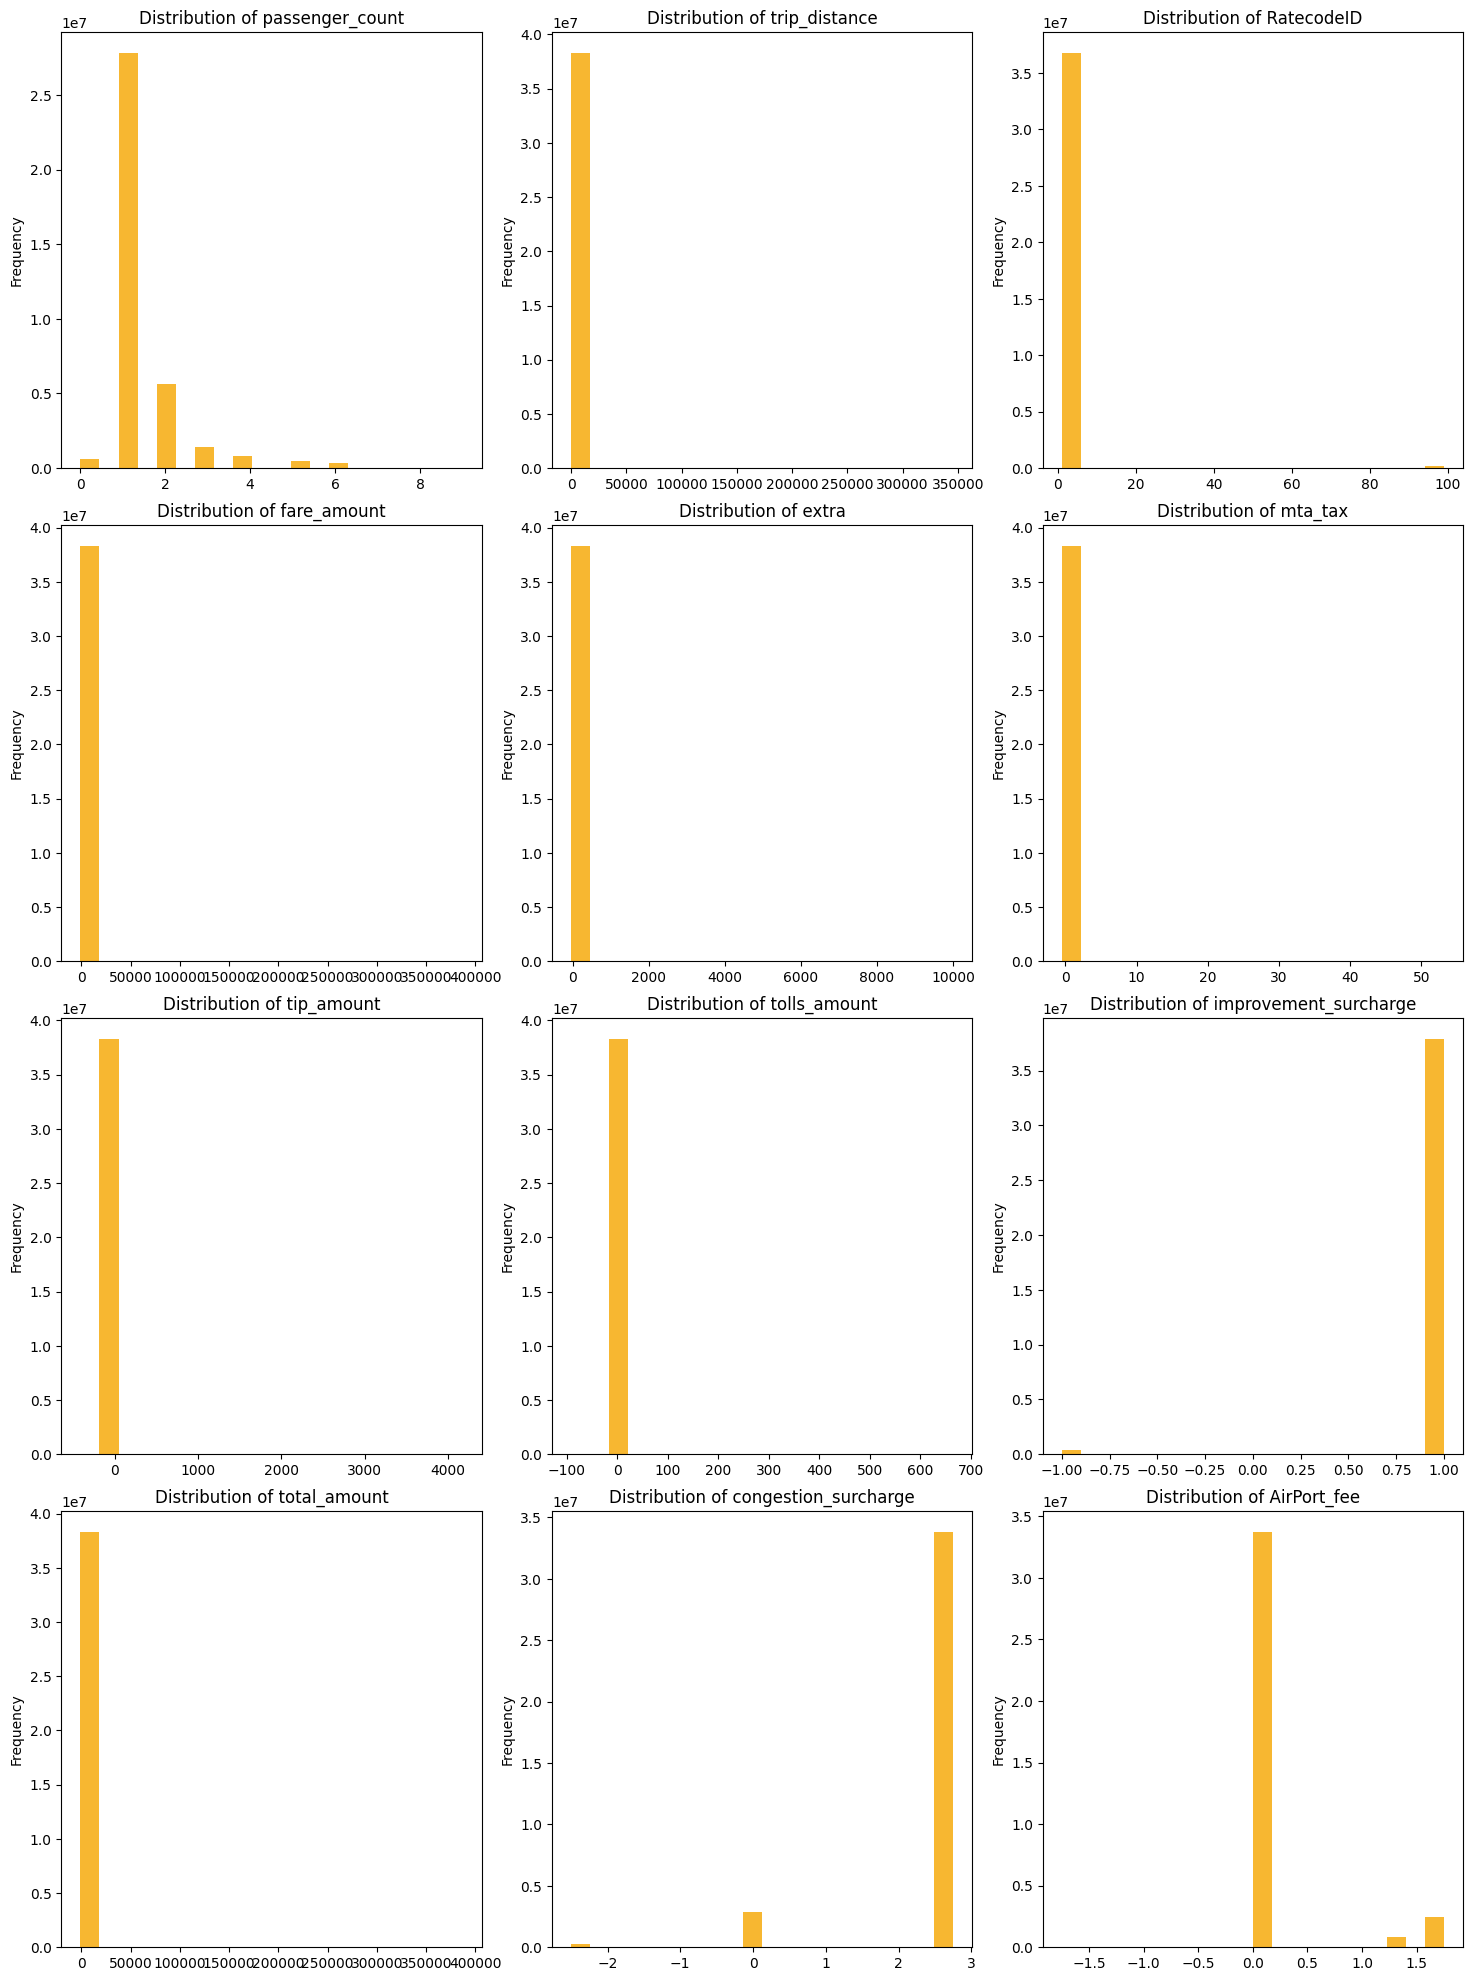

In [17]:
num_cols = len(list(merged_data.select_dtypes(include='float64')))
num_rows = (num_cols - 1) // 3 + 1
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
plt.tight_layout(pad=2.0)

for i, column in enumerate(list(merged_data.select_dtypes(include='float64'))):
    row = i // 3
    col = i % 3
    merged_data[column].plot(kind='hist', ax=axs[row, col], title=f'Distribution of {column}', color='#f7b731', bins=20)

plt.show()

In [18]:
merged_data['travel_time'] = merged_data['tpep_dropoff_datetime'] - merged_data['tpep_pickup_datetime']
travel_time_sorted = merged_data.sort_values(['travel_time'], ascending=False)
travel_time_sorted

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee,travel_time
2127658,2,2023-01-23 11:21:51,2023-01-30 10:31:02,1.0,0.0,1.0,N,207,95,2,3.0,0.0,0.5,0.0,0.0,1.0,4.5,0.0,0.0,6 days 23:09:11
15333535,2,2023-05-24 12:51:56,2023-05-31 11:19:03,1.0,0.0,1.0,N,207,226,2,3.0,0.0,0.5,0.0,0.0,1.0,4.5,0.0,0.0,6 days 22:27:07
23763760,2,2023-08-16 08:19:21,2023-08-22 16:36:26,1.0,0.0,1.0,N,207,207,2,3.0,0.0,0.5,0.0,0.0,1.0,4.5,0.0,0.0,6 days 08:17:05
22522817,2,2023-08-02 11:05:52,2023-08-08 17:20:46,1.0,0.0,1.0,N,207,226,2,3.7,0.0,0.5,0.0,0.0,1.0,5.2,0.0,0.0,6 days 06:14:54
25058918,2,2023-08-31 08:33:05,2023-09-05 11:05:12,1.0,0.0,1.0,N,207,132,2,3.0,0.0,0.5,0.0,0.0,1.0,4.5,0.0,0.0,5 days 02:32:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593726,1,2023-09-14 15:46:00,2023-09-14 13:00:57,1.0,3.5,99.0,N,3,213,1,27.5,0.0,0.5,0.0,0.0,1.0,29.0,0.0,0.0,-1 days +21:14:57
6829705,1,2023-03-08 21:04:03,2023-03-08 13:07:48,1.0,0.2,99.0,N,75,75,1,22.5,0.0,0.5,0.0,0.0,1.0,24.0,0.0,0.0,-1 days +16:03:45
26223835,1,2023-09-11 10:17:05,2023-09-11 00:00:00,1.0,0.0,1.0,N,161,50,1,18.9,0.0,0.0,0.0,0.0,0.0,18.9,0.0,0.0,-1 days +13:42:55
27554519,1,2023-09-27 16:29:00,2023-09-26 20:52:00,1.0,9.0,99.0,N,42,135,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1 days +04:23:00


**Observations and insights**

Following travel time analysys I can see that some trips take longer than a day with a travel time equals zero. I assume they can be removed safely.

For some trips pick up and drop off times need to be swapped (where tavel lime is a negative number.)

Seing 1970-01-20 10:16:32 in a drop off column indicates that dates need to be checked to include only 2023.

In [19]:
merged_data['payment_type'].value_counts()

payment_type
1    29856932
2     6405059
0     1309356
4      498015
3      240862
5           2
Name: count, dtype: int64

**Observations and insights**

I assume that in the dataset, payment_type is encoded in the following integers:

0. Credit card
1. Cash
2. No charge
3. Dispute
4. Unknown
5. Voided trips

According to [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) for Yellow Taxi Trip Records (updated in May 11 2022) the payment type shold be represented as following:

| Field Name | Description |
| -------- | ------- |
| Payment_type | A numeric code signifying how the passenger paid for the trip. **1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip** |

Investigate if 5 represent voided trip(6) and 0 represent cash. 

In [20]:
merged_data[merged_data['payment_type']==5]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee,travel_time
8050105,1,2023-03-20 00:21:17,2023-03-20 01:00:24,1.0,12.1,2.0,Y,132,137,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:39:07
16656441,1,2023-06-05 10:08:32,2023-06-05 10:09:58,1.0,0.0,1.0,N,50,50,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 days 00:01:26


In [21]:
# Is taximeter broken?!
merged_data[merged_data['payment_type']==0]\
[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'total_amount']]\
.sort_values(by=['trip_distance'],ascending=False)

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,fare_amount,total_amount
25178451,2023-08-15 04:02:00,2023-08-15 04:13:00,345729.44,13.27,17.27
16115613,2023-05-11 09:30:00,2023-05-11 09:57:00,342344.85,-0.11,3.89
5959075,2023-02-21 05:19:00,2023-02-21 05:36:00,335004.33,17.75,23.93
12672047,2023-04-30 18:37:00,2023-04-30 19:02:00,296881.42,28.39,38.87
28053740,2023-09-28 13:35:00,2023-09-28 14:53:00,265869.44,76.02,86.96
...,...,...,...,...,...
34888457,2023-11-19 02:27:57,2023-11-19 02:38:24,0.00,11.59,15.59
34888456,2023-11-19 02:08:51,2023-11-19 02:21:13,0.00,21.50,25.50
31469679,2023-10-07 13:35:27,2023-10-07 14:07:26,0.00,35.72,39.72
34888454,2023-11-19 02:57:37,2023-11-19 03:18:03,0.00,32.32,36.32


/var/folders/db/ws2nq6f13qz9r4swjw9ww95r0000gn/T/ipykernel_53645/1860061189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(ylabels)


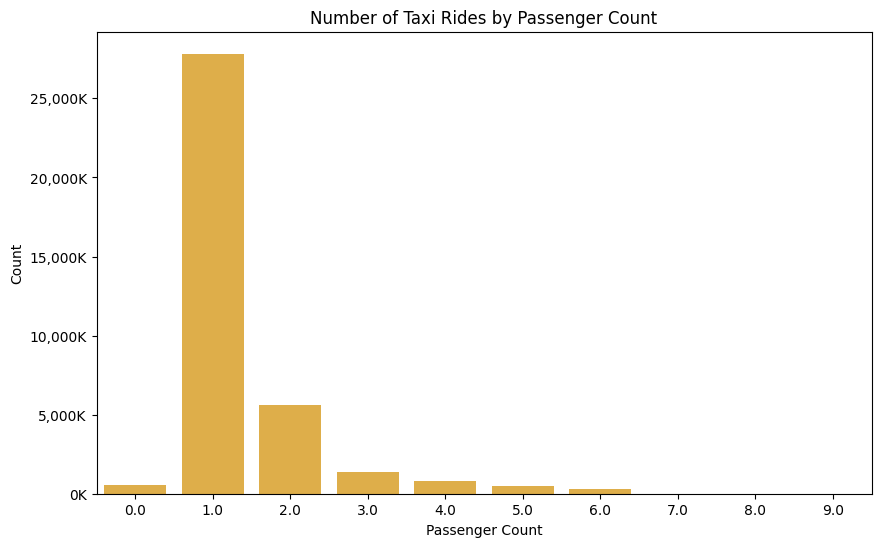

In [22]:
passenger_counts = merged_data['passenger_count'].value_counts().reset_index()
passenger_counts.columns = ['passenger_count', 'count']

plt.figure(figsize=(10, 6))
g = sns.barplot(data=passenger_counts, x='passenger_count', y='count', color='#f7b731')
ylabels = ['{:,.0f}'.format(y) + 'K' for y in g.get_yticks()/1000]
g.set_yticklabels(ylabels)
plt.xlabel('Passenger Count')
plt.ylabel('Count')
plt.title('Number of Taxi Rides by Passenger Count')
plt.show()

In [23]:
merged_data[merged_data['passenger_count']==0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,AirPort_fee,travel_time
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.9,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0 days 00:09:37
485,1,2023-01-01 00:22:18,2023-01-01 00:28:17,0.0,1.3,1.0,N,170,107,1,8.6,3.50,0.5,2.70,0.0,1.0,16.30,2.5,0.00,0 days 00:05:59
486,1,2023-01-01 00:30:59,2023-01-01 00:34:46,0.0,1.0,1.0,N,79,107,1,6.5,3.50,0.5,2.30,0.0,1.0,13.80,2.5,0.00,0 days 00:03:47
487,1,2023-01-01 00:36:19,2023-01-01 00:43:46,0.0,2.3,1.0,N,107,232,1,11.4,3.50,0.5,3.25,0.0,1.0,19.65,2.5,0.00,0 days 00:07:27
488,1,2023-01-01 00:54:23,2023-01-01 01:08:18,0.0,2.1,1.0,N,79,231,2,12.8,3.50,0.5,0.00,0.0,1.0,17.80,2.5,0.00,0 days 00:13:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38129468,1,2023-12-31 23:18:56,2023-12-31 23:26:07,0.0,1.7,1.0,N,141,75,1,10.0,3.50,0.5,3.00,0.0,1.0,18.00,2.5,0.00,0 days 00:07:11
38129469,1,2023-12-31 23:44:04,2023-12-31 23:53:59,0.0,1.5,1.0,N,229,164,4,11.4,3.50,0.5,0.00,0.0,1.0,16.40,2.5,0.00,0 days 00:09:55
38129992,1,2023-12-31 23:12:44,2023-12-31 23:28:32,0.0,6.4,1.0,N,87,68,2,28.9,3.50,0.5,0.00,0.0,1.0,33.90,2.5,0.00,0 days 00:15:48
38130121,1,2023-12-31 23:40:12,2023-12-31 23:52:15,0.0,1.9,1.0,N,260,173,1,12.8,1.00,0.5,1.00,0.0,1.0,16.30,0.0,0.00,0 days 00:12:03


**Observations and insights**

The biggest amount of yellow cab trips carry 1-2 passengers, with single ride being most common. 

What is interesting to investigate here is characteristics of zero-passenger trips (duration, start and end points - to see if taxis are used here as delivery vehicles), but for now it's out of this project's scope.

In [24]:
# Average tip for trips paid for with credit card
avg_cc_tip = merged_data[merged_data['payment_type']==0]['tip_amount'].mean()
print('Avg. ccredit card tip:', avg_cc_tip)

# Average tip for trips paid for with cash
avg_cash_tip = merged_data[merged_data['payment_type']==1]['tip_amount'].mean()
print('Avg. cash tip:', avg_cash_tip)

Avg. ccredit card tip: 2.7739578235407314
Avg. cash tip: 4.396300929043871


In [25]:
merged_data['VendorID'].value_counts()

VendorID
2    28263844
1    10037714
6        8668
Name: count, dtype: int64

In [26]:
# Average amount paid for each vendor
merged_data.groupby(['VendorID']).mean(numeric_only=True)[['total_amount']]

,total_amount
VendorID,
1,27.228547
2,28.894853
6,45.157738


In [27]:
# Cash payment by passenger count
cash = merged_data[merged_data['payment_type']==1]
cash['passenger_count'].value_counts()

passenger_count
1.0    22698465
2.0     4421685
3.0     1071163
4.0      558370
0.0      456885
5.0      393234
6.0      256775
8.0         224
7.0          85
9.0          46
Name: count, dtype: int64

In [28]:
# Average tip amount for each passenger count (cash payments only)
cash.groupby(['passenger_count']).mean(numeric_only=True)[['tip_amount']]

,tip_amount
passenger_count,
0.0,3.892517
1.0,4.289000
2.0,4.858613
3.0,4.677780
4.0,5.008497
5.0,4.360620
6.0,4.355261
7.0,8.971765
8.0,12.779598
